# 12. Predicting Emotion Intensity 

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

import math

/Users/michaelc.c.h/opt/miniconda3/envs/brain2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Description

Prediction with neural nets simple MLP for emotion classifications from gradients "to specify what we extract exactly"
OR 
predict intensity values group level during specific movie
GOAL: Predict class of emotions from extracted features of group level gradients 

## Table of Contents
- [Predictive within Same Movie]()
    - [Features Preparation](#feature)
    - [NN Model](#nn)
    - [Train and Prediction](#tpred)
    
- [Predictive train Movie and other pred movie]()

- [Predictive with groups of movies]()
- [(for fun) Apply group of movies trained model to group rest]()

## Predictive within Same Movie

<a class="anchor" id="feature"></a>
### Feature Preparation

In [1279]:
networks = list(index2region.keys()) #remove Sub for now

select   = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

In [767]:
# extract from emoBIDS intensity values ?
emo_df = pd.read_csv('./data/emotion_compileBIDS.csv')
emo_df.filename.unique()

array(['W_AfterTheRain13.csv', 'W_BetweenViewing13.csv',
       'W_BigBuckBunny13.csv', 'W_Chatter13.csv', 'W_FirstBite13.csv',
       'W_LessonLearned13.csv', 'W_Payload13.csv', 'W_Sintel13.csv',
       'W_Spaceman13.csv', 'W_Superhero13.csv', 'W_TearsOfSteel13.csv',
       'W_TheSecretNumber13.csv', 'W_ToClaireFromSonny13.csv',
       'W_YouAgain13.csv'], dtype=object)

In [1280]:
moviename = "Sintel"

eg    = 'W_{}13.csv'.format(moviename)
eg_df = emo_df[emo_df.filename == eg]

emo_array = []
emo_label = []
for emo in eg_df.item.unique():
    if emo in select:
        emo_array.append(np.array(eg_df[eg_df.item == emo].score))
        emo_label.append(emo)

emo_array = np.asarray(emo_array)

# Remove reduncdant emotions, meaning colinear vectors
colinear = (np.abs(FC(emo_array.T)) - np.eye(13)) > 0.99 # arbitrary thresh
keep = []
for i in range(len(colinear)):
    redundant = np.where(colinear[i])[0]
    if np.sum([r in keep for r in redundant]) == 0:
        keep.append(i)
    else:
        print(i)
keep       = np.array(keep)
emo_label  = np.array(emo_label)[keep]
decolinear = emo_array[keep]

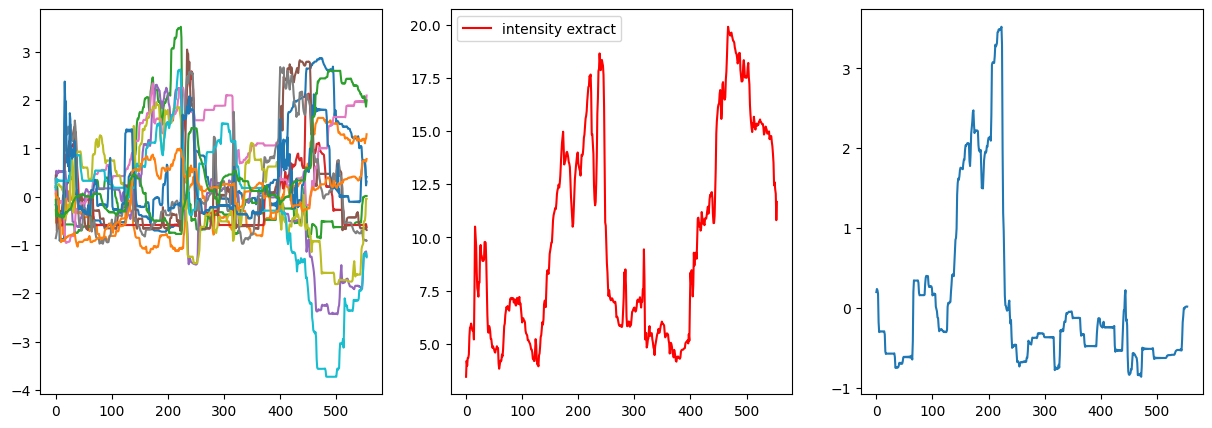

In [1281]:
# selected gradients moments?
# predict moments of gradients 
intensity = np.abs(decolinear).sum(axis=0)
single    = decolinear[np.argmax(decolinear.max(axis=1))]

fig, ax   = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(decolinear.T)
ax[1].plot(intensity, c='r', label='intensity extract')
ax[1].legend()
ax[2].plot(single)
plt.show()

(555,)

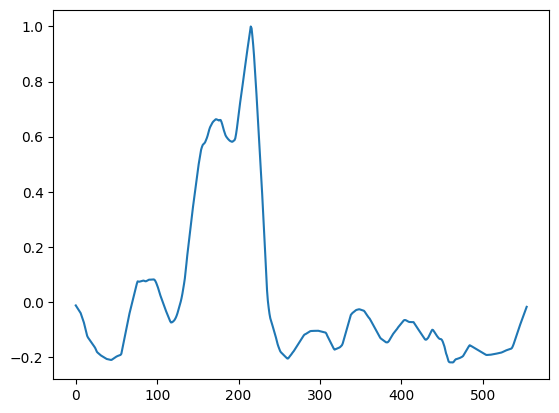

In [1282]:
ws = 20
# featureY = overlap_add(single, wsize=ws)
featureY = low_pass(single,ws)
featureY = featureY/featureY.max()
# plt.plot(single)
plt.plot(featureY)
# plt.plot(tmp)
featureY.shape

In [1283]:
# load dynamic gradients
featureX = load('./resources/dynamic_grad/group_level414/{}_40_grad.pkl'.format(moviename))[0][:,:,:3]
# featureX = featureX.reshape(len(featureX), -1)


# # if feature extracted the regions concentration
# A = np.zeros((featureX.shape[0], len(networks)))
# for p in range(featureX.shape[0]):
#     for nidx, n in enumerate(networks):
#         A[p,nidx] = network_volume(featureX[p], n)
# featureX = deepcopy(A)


# same sizing
L = min(len(featureX), len(featureY))
print(len(featureX), len(featureY))
featureX = featureX[:L]
featureY = featureY[:L]

556 555


Spare test set

In [1259]:
moviename

'YouAgain'

(test,  val)
- AfterTheRain: (0,50) (300,350) 
- BetweenViewing: (400,500) (500,600)
- BigBuckBunny: (0,50) (300,350) 
- Chatter: (0,50) (200,250)
- FirstBite: (0,50) (300,350)
- LessonLearned: (0,50) (300,350)
- Payload: (400,500) (500,600) (didn't finish converge with patience 6, just kept full 1000)
- Sintel: (200,300) (400,500) 
- Spaceman: (200,300) (400,500) 
- Superhero: (200,300) (400,500)
- TearsOfSteel: (0,50) (300,350)
- TheSecretNumber: (200,300) (400,500)
- ToClaireFromSonny: (0,50) (200,250)
- YouAgain: (200,300) (400,500)

In [1284]:
np.random.seed(10)

test_idx    = np.arange(200,300)
val_idx     = np.arange(400,500)
working_idx = np.array(list(set(np.arange(len(featureX))) - set(test_idx) - set(val_idx)))

x_train = featureX[working_idx]
y_train = featureY[working_idx]

x_valid = featureX[val_idx]
y_valid = featureY[val_idx]

x_test  = featureX[test_idx]
y_test  = featureY[test_idx]

### NN Model

In [1286]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [1288]:
x_train = torch.tensor(x_train).to(device).type(torch.FloatTensor)
x_valid = torch.tensor(x_valid).to(device).type(torch.FloatTensor)
y_train = torch.tensor(y_train).to(device).type(torch.FloatTensor)
y_valid = torch.tensor(y_valid).to(device).type(torch.FloatTensor)
x_test  = torch.tensor(x_test).to(device).type(torch.FloatTensor)
y_test  = torch.tensor(y_test).to(device).type(torch.FloatTensor)

x_train.dtype

NOTE USEFUL: sklearn.utils.shuffle

### Train and Validation

In [1291]:
nb_epoch   = 1001
batch_size = 48

input_dim  = np.prod(featureX.shape[1:])

In [1294]:
np.random.seed(93) # general randomness seed
torch.manual_seed(93) # weight initialization randomness seed

mlp     = MLP(input_dim).to(device)
# loss_fn = nn.MSELoss() 
loss_fn = CombinePearsonLoss()
# optimizer = optim.SGD(mlp.parameters(),  lr=1e-7)
optimizer = optim.Adam(mlp.parameters(),  lr=1e-5)

logs = {'train': [], 'validation': [], 'test': []}

size = x_train.shape[0]

patience  = 6
flagcount = 0
for epoch in range(nb_epoch):
    
    for i in range(math.ceil(size/batch_size)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = x_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlp(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # print statistics for train and validation set
    with torch.no_grad():
        # train
        train_pred = mlp(x_train)
        train_loss = loss_fn(train_pred, y_train)
        
        # validation 
        val_pred = mlp(x_valid)
        val_loss = loss_fn(val_pred, y_valid)
        
        test_pred = mlp(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        if epoch % 1000 == 0:
            print("##################")
            print("Epoch {} Combine loss per sample is {} (Train)".format(epoch, train_loss))
            print("Epoch {} Combine loss per sample is {} (Validation)\n".format(epoch, val_loss))
            print("Epoch {} Combine loss per sample is {} (Test)\n".format(epoch, test_loss))
        
        
        # Early Stop
        if len(logs['validation'])!=0:
            if (val_loss - logs['validation'][-1]) > 1e-1: flagcount += 1
                
        if flagcount > patience: 
            print("##################")
            print("Epoch {} Combine loss per sample is {} (Train)".format(epoch, train_loss))
            print("Epoch {} Combine loss per sample is {} (Validation)\n".format(epoch, val_loss))
            print("Epoch {} Combine loss per sample is {} (Test)\n".format(epoch, test_loss))            
            print('Early Stop Criterion')
            break
        
        logs['train'].append(train_loss)
        logs['validation'].append(val_loss)
        logs['test'].append(test_loss)

##################
Epoch 0 Combine loss per sample is 12.986907005310059 (Train)
Epoch 0 Combine loss per sample is 17.220861434936523 (Validation)

Epoch 0 Combine loss per sample is 5.812959671020508 (Test)

##################
Epoch 788 Combine loss per sample is 0.29562580585479736 (Train)
Epoch 788 Combine loss per sample is 3.3261590003967285 (Validation)

Epoch 788 Combine loss per sample is 1.2883670330047607 (Test)

Early Stop Criterion


In [1275]:
save('./resources/mlp_logs/{}_logs.pkl'.format(moviename),
     {'train': (train_pred, y_train), 'val': (val_pred, y_valid), 'test': (test_pred, y_test)})

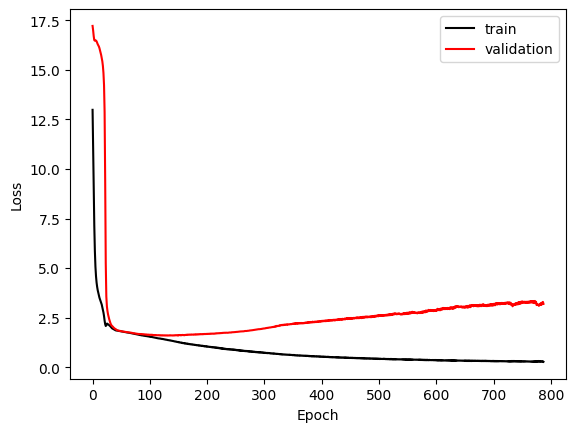

In [1295]:
plt.plot(logs['train'], label='train', color='k')
plt.plot(logs['validation'], label='validation', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.plot(logs['test'])
# plt.yscale('log')

Text(0, 0.5, 'normalized emotion timecourse')

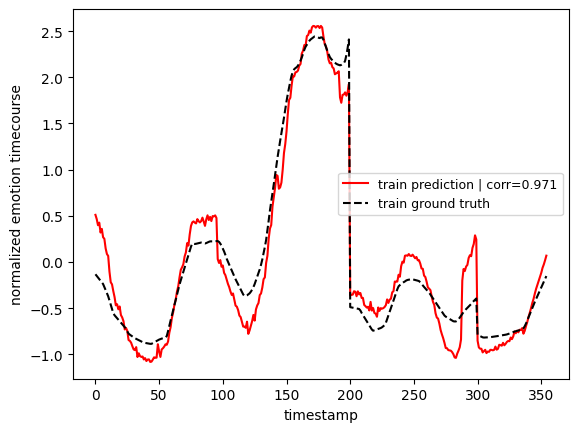

In [1296]:
# plt.plot(train_pred[np.argsort(y_train)])
# plt.plot(y_train[np.argsort(y_train)])

corr = pearson_correlation(train_pred, y_train)

plt.plot(zscore(train_pred), label='train prediction | corr={}'.format(round(corr,3)), color='r')
plt.plot(zscore(y_train), label='train ground truth', color='k', linestyle='--')
plt.legend(prop={'size':9})
plt.xlabel('timestamp')
plt.ylabel('normalized emotion timecourse')


Text(0, 0.5, 'normalized emotion timecourse')

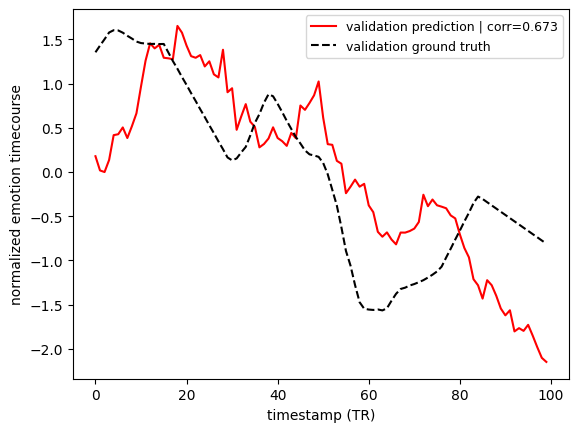

In [1297]:
# plt.plot(val_pred[np.argsort(y_valid)])
# plt.plot(y_valid[np.argsort(y_valid)])

corr = pearson_correlation(val_pred, y_valid)

plt.plot(zscore(val_pred), label='validation prediction | corr={}'.format(round(corr,3)), color='r')
plt.plot(zscore(y_valid), label='validation ground truth', color='k', linestyle='--')
plt.legend(prop={'size':9})
plt.xlabel('timestamp (TR)')
plt.ylabel('normalized emotion timecourse')


Text(0, 0.5, 'normalized emotion timecourse')

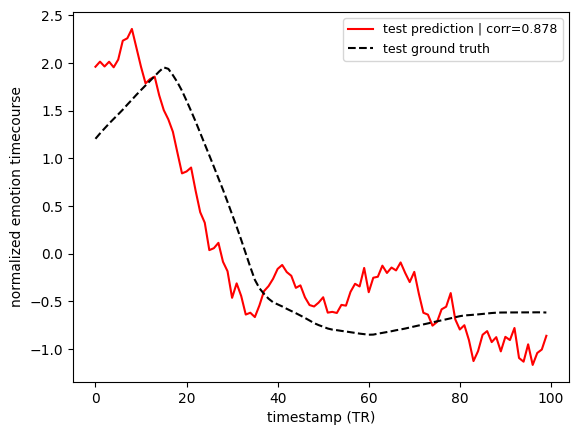

In [1298]:
# plt.plot(val_pred[np.argsort(y_valid)])
# plt.plot(y_valid[np.argsort(y_valid)])

corr = pearson_correlation(test_pred, y_test)

plt.plot(zscore(test_pred), label='test prediction | corr={}'.format(round(corr,3)), color='r')
plt.plot(zscore(y_test), label='test ground truth', color='k', linestyle='--')
plt.legend(prop={'size':9})
plt.xlabel('timestamp (TR)')
plt.ylabel('normalized emotion timecourse')

In [1299]:
weight_combination = mlp.fc3.weight.detach().matmul(mlp.fc2.weight.detach())
weight_combination = weight_combination.matmul(mlp.fc1.weight.detach())
weight_combination = weight_combination.numpy().reshape(414,3)

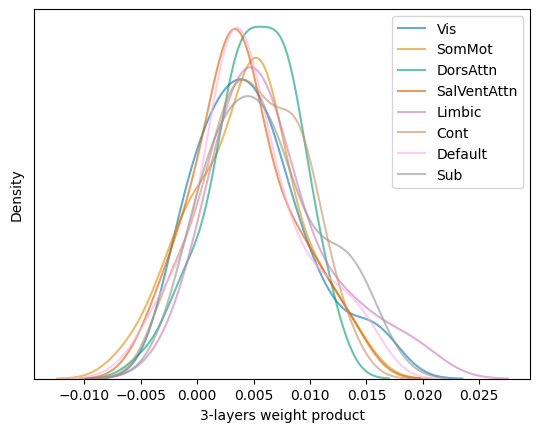

In [1300]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)

for idx,net in enumerate(networks):
    curweight = weight_combination[index2region[net], : ]
    sns.kdeplot(curweight.max(axis=1), alpha=0.6, color=my_cmap.colors[idx], label=net)

plt.xlabel('3-layers weight product')
plt.yticks([])
plt.legend()

In [4]:
logs = os.listdir('./resources/mlp_logs')
df   = {log.split('_')[0]:[] for log in logs}
for log in logs:
    log_acc = load('./resources/mlp_logs/{}'.format(log))
    filename = log.split('_')[0]
    t1,t2 = log_acc['train']
    v1,v2 = log_acc['val']
    te1,te2 = log_acc['test']

    df[filename].append(round(pearson_correlation(t1,t2),3))
    df[filename].append(round(pearson_correlation(v1,v2),3))
    df[filename].append(round(pearson_correlation(te1,te2),3))
    
df = pd.DataFrame.from_dict(df)

df.index = ['train', 'val', 'test']
print(df.iloc[:,7:].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  BigBuckBunny &  BetweenViewing &  Payload &  FirstBite &  YouAgain &  Chatter &  TheSecretNumber \\
\midrule
train &         0.989 &           0.435 &    0.961 &      0.992 &     0.686 &    0.992 &            0.992 \\
val   &         0.892 &           0.466 &    0.235 &      0.967 &     0.526 &    0.877 &            0.584 \\
test  &         0.631 &           0.134 &    0.325 &      0.390 &     0.744 &    0.056 &            0.413 \\
\bottomrule
\end{tabular}



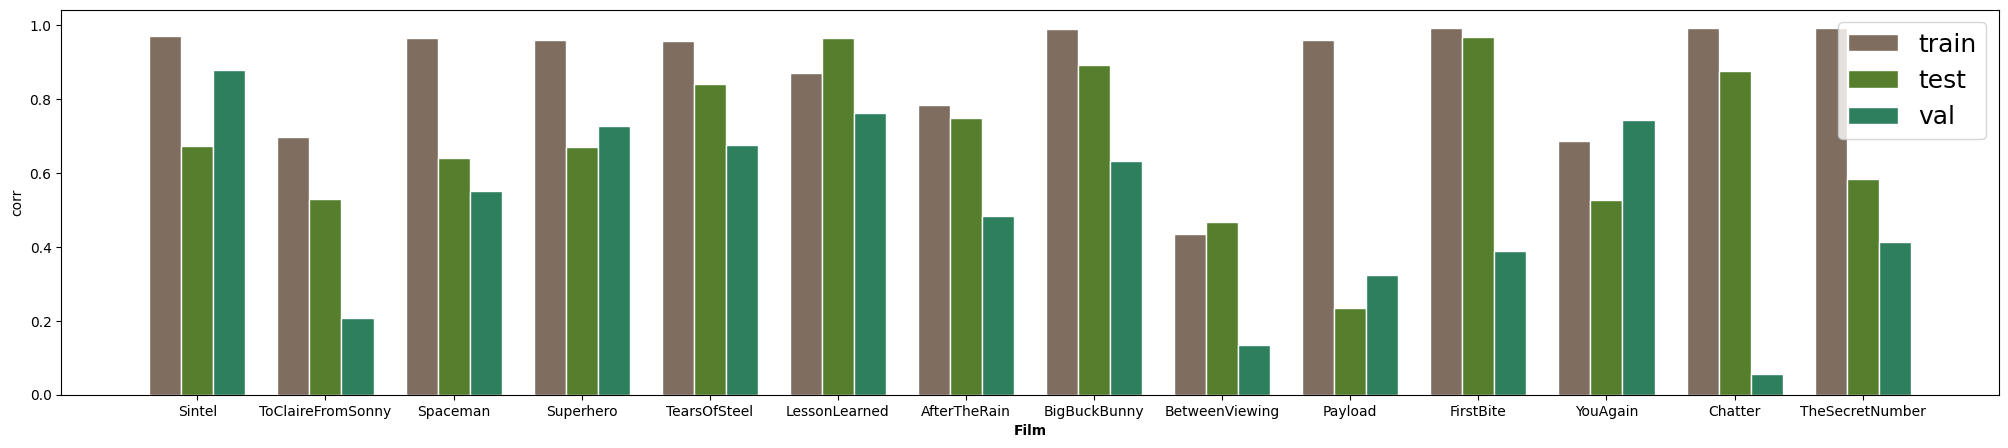

In [22]:
# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = list(df.iloc[0])
bars2 = list(df.iloc[1])
bars3 = list(df.iloc[2])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.figure(figsize=(25,5))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='test')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='val')


plt.ylabel('corr')
# Add xticks on the middle of the group bars
plt.xlabel('Film', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], df.columns)

# Create legend & Show graphic
plt.legend(loc=1, prop={'size':18})
plt.show()

In [5]:
pdf = {'mean': np.round(np.array(list(df.mean(axis=1))),3), 'std': np.round(np.array(list(df.std(axis=1))),3) }
pdf = pd.DataFrame.from_dict(pdf)
pdf.index = ['train', 'val', 'test']

In [6]:
pdf

mean    std
train  0.875  0.167
val    0.687  0.211
test   0.498  0.254

## Predictive train Movie to other  Movie

In [189]:
eg    = 'W_Payload13.csv'
eg_df = emo_df[emo_df.filename == eg]

emo_array = []
for emo in eg_df.item.unique():
    if emo in select:
        emo_array.append(np.array(eg_df[eg_df.item == emo].score))

emo_array = np.asarray(emo_array)

# Remove reduncdant emotions, meaning colinear vectors
colinear = (np.abs(FC(emo_array.T)) - np.eye(13)) > 0.80 # arbitrary thresh
keep = []
for i in range(len(colinear)):
    redundant = np.where(colinear[i])[0]
    if np.sum([r in keep for r in redundant]) == 0:
        keep.append(i)
    else:
        print(i)
keep       = np.array(keep)
decolinear = emo_array[keep]

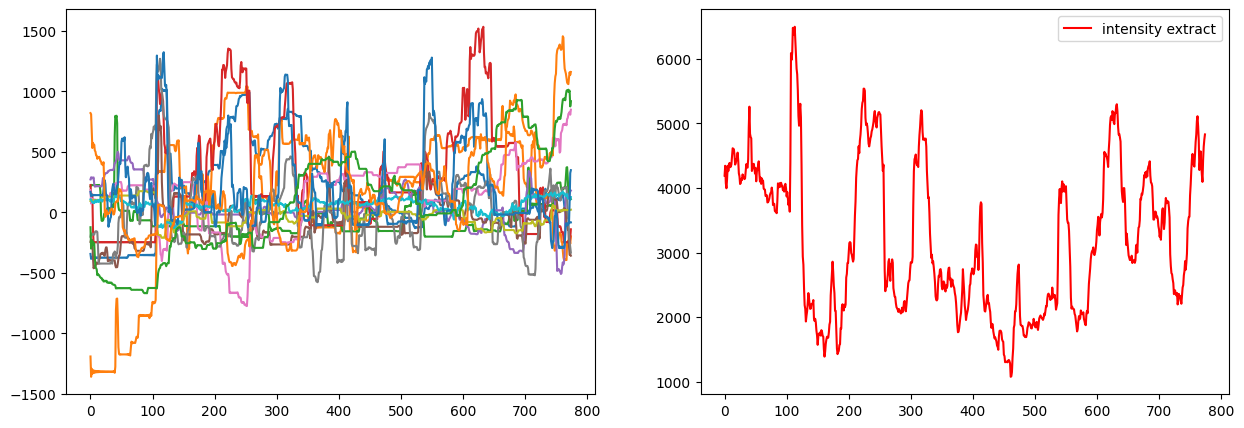

In [190]:
# selected gradients moments?
# predict moments of gradients 
intensity = np.abs(decolinear).sum(axis=0)

fig, ax   = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(decolinear.T)
ax[1].plot(intensity, c='r', label='intensity extract')
ax[1].legend()
plt.show()

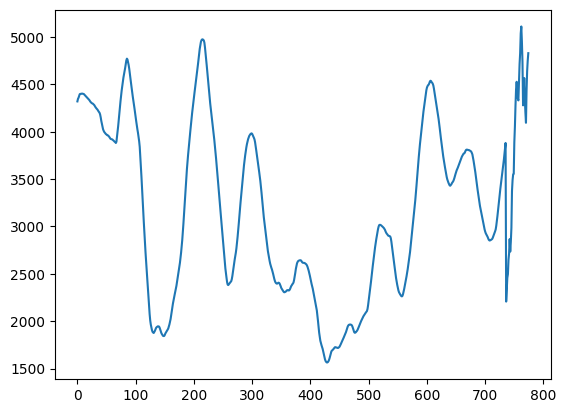

In [191]:
ws = 40
featureY = overlap_add(intensity, wsize=ws, pad=True)
plt.plot(featureY)

In [198]:
# load dynamic gradients
featureX = load('./resources/dynamic_grad/group_level/Payload_40_grad.pkl')[0][:,:,:3]
# featureX = featureX.reshape(len(featureX), -1)

# if feature extracted the regions concentration
A = np.zeros((featureX.shape[0], len(networks)))
for p in range(featureX.shape[0]):
    for nidx, n in enumerate(networks):
        A[p,nidx] = network_volume(featureX[p], n)
featureX = deepcopy(A)

# same sizing
L = min(len(featureX), len(featureY))
featureX = featureX[:L]
featureY = featureY[:L]

In [194]:
featureX = torch.tensor(featureX).to(device).type(torch.FloatTensor)
featureY = torch.tensor(featureY).to(device).type(torch.FloatTensor)

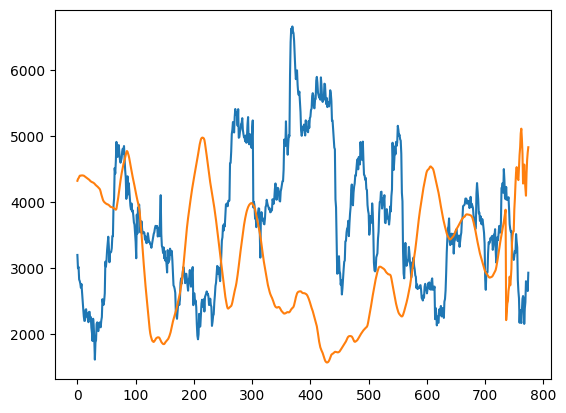

In [195]:
with torch.no_grad():
    other_pred = mlp(featureX)
plt.plot(other_pred)
plt.plot(featureY)

## Predictive with groups of movies

In [289]:
# all movies order
movie_order = emo_df.filename.unique()

In [514]:
fX, fY = [], []
for m in tqdm(movie_order):
    moviename = m[2:-6]
    eg_df     = emo_df[emo_df.filename == m]

#     emo_array = []
#     for emo in eg_df.item.unique():
#         if emo in select:
#             emo_array.append(np.array(eg_df[eg_df.item == emo].score))

#     emo_array = np.asarray(emo_array)

#     # Remove reduncdant emotions, meaning colinear vectors
#     colinear = (np.abs(FC(emo_array.T)) - np.eye(13)) > 0.80 # arbitrary thresh
#     keep     = []
#     for i in range(len(colinear)):
#         redundant = np.where(colinear[i])[0]
#         if np.sum([r in keep for r in redundant]) == 0:
#             keep.append(i)
#     keep       = np.array(keep)
#     decolinear = emo_array[keep]
#     intensity  = np.abs(decolinear).sum(axis=0)

    intensity = np.array(eg_df[eg_df.item == select[0]].score)
    ws        = 20
    featureY  = low_pass(intensity, ws)
    featureX  = load('./resources/dynamic_grad/group_level/{}_40_grad.pkl'.format(moviename))[0][:,:,:3]

#     A = np.zeros((featureX.shape[0], len(networks)))
#     for p in range(featureX.shape[0]):
#         for nidx, n in enumerate(networks):
#             A[p,nidx] = network_volume(featureX[p], n)
#     featureX = deepcopy(A)
    
    
    L        = min(len(featureX), len(featureY))
    featureX = featureX[:L]
    featureY = featureY[:L]
    
    fX.append(featureX)
    fY.append(featureY)

fX = np.concatenate(fX)
fY = np.concatenate(fY)

  0%|          | 0/14 [00:00<?, ?it/s]

In [531]:
aligned, ref, score = procrustes_align(list(fX))
fX = np.asarray(aligned)

Spare Test Set

In [544]:
np.random.seed(10)

test_idx    = np.arange(6000,7385)
val_idx     = np.arange(5000,6000)
working_idx = np.array(list(set(np.arange(len(fX))) - set(test_idx) - set(val_idx)))

x_train = fX[working_idx]
y_train = fY[working_idx]

x_valid = fX[val_idx]
y_valid = fY[val_idx]

x_test  = fX[test_idx]
y_test  = fY[test_idx]

In [545]:
x_train = torch.tensor(x_train).to(device).type(torch.FloatTensor)
x_valid = torch.tensor(x_valid).to(device).type(torch.FloatTensor)
y_train = torch.tensor(y_train).to(device).type(torch.FloatTensor)
y_valid = torch.tensor(y_valid).to(device).type(torch.FloatTensor)
x_test  = torch.tensor(x_test).to(device).type(torch.FloatTensor)
y_test  = torch.tensor(y_test).to(device).type(torch.FloatTensor)

In [546]:
nb_epoch   = 2000
batch_size = 48

In [547]:
input_dim  = np.prod(fX.shape[1:])

In [548]:
np.random.seed(93)
mlp     = MLP(input_dim).to(device)
loss_fn = CombinePearsonLoss()
# optimizer = optim.SGD(mlp.parameters(),  lr=1e-3)
optimizer = optim.Adam(mlp.parameters(),  lr=1e-5)

logs = {'train': [], 'validation': [], 'test': []}

size = x_train.shape[0]
for epoch in range(nb_epoch):
    
    for i in range(math.ceil(size/batch_size)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = x_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlp(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # print statistics for train and validation set
    with torch.no_grad():
        # train
        train_pred = mlp(x_train)
        train_loss = loss_fn(train_pred, y_train)
        
        # validation 
        val_pred = mlp(x_valid)
        val_loss = loss_fn(val_pred, y_valid)
        
        test_pred = mlp(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        if epoch % 100 == 0:
            print("##################")
            print("Epoch {} MSE loss per sample is {} (Train)".format(epoch, train_loss))
            print("Epoch {} MSE loss per sample is {} (Validation)\n".format(epoch, val_loss))
            print("Epoch {} MSE loss per sample is {} (Test)\n".format(epoch, test_loss))            
        
        logs['train'].append(train_loss)
        logs['validation'].append(val_loss)
        logs['test'].append(test_loss)        

##################
Epoch 0 MSE loss per sample is 10.555356979370117 (Train)
Epoch 0 MSE loss per sample is 8.205039978027344 (Validation)

Epoch 0 MSE loss per sample is 10.207418441772461 (Test)

##################
Epoch 100 MSE loss per sample is 3.0003812313079834 (Train)
Epoch 100 MSE loss per sample is 7.974753379821777 (Validation)

Epoch 100 MSE loss per sample is 8.818324089050293 (Test)

##################
Epoch 200 MSE loss per sample is 2.1692869663238525 (Train)
Epoch 200 MSE loss per sample is 6.1019978523254395 (Validation)

Epoch 200 MSE loss per sample is 8.308509826660156 (Test)

##################
Epoch 300 MSE loss per sample is 1.6608659029006958 (Train)
Epoch 300 MSE loss per sample is 6.653078556060791 (Validation)

Epoch 300 MSE loss per sample is 7.952206611633301 (Test)

##################
Epoch 400 MSE loss per sample is 1.2689083814620972 (Train)
Epoch 400 MSE loss per sample is 6.870359897613525 (Validation)

Epoch 400 MSE loss per sample is 8.3726186752319

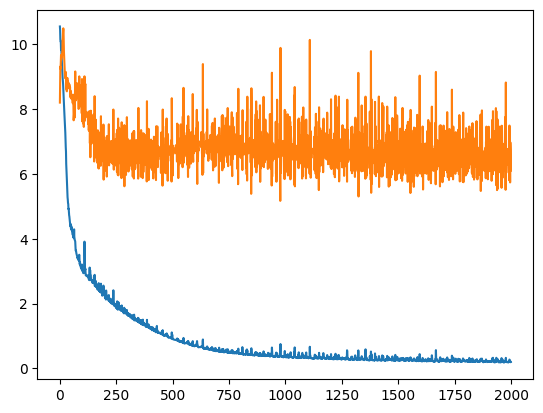

In [550]:
plt.plot(logs['train'])
plt.plot(logs['validation'])

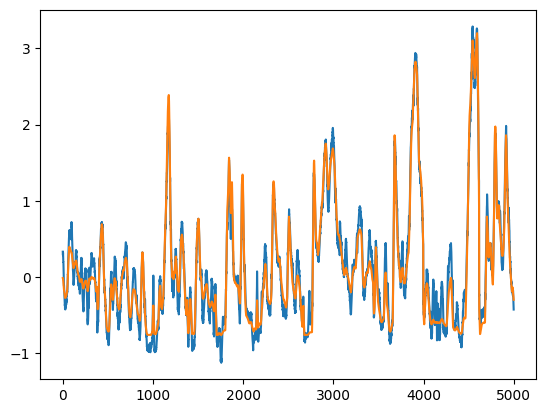

In [551]:
plt.plot(train_pred)
plt.plot(y_train)

0.411931338140247

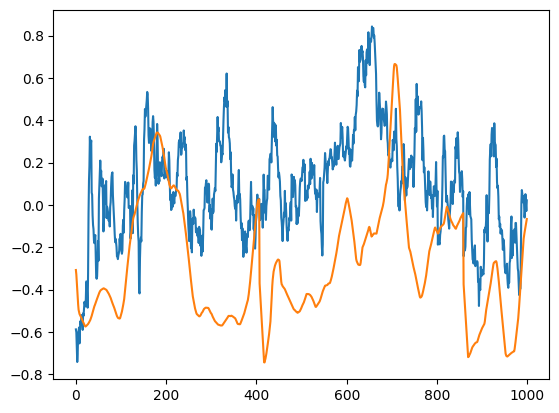

In [552]:
plt.plot(val_pred)
plt.plot(y_valid)
pearson_correlation(val_pred, y_valid)

0.21003755081132963

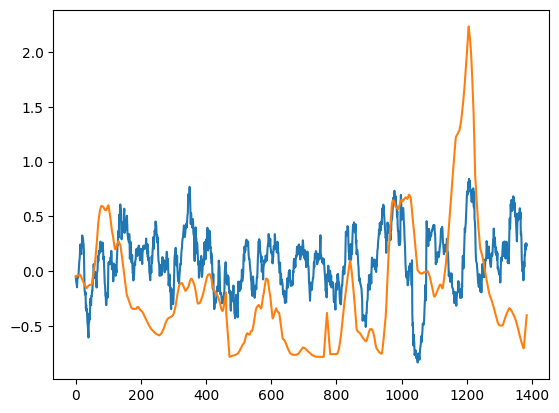

In [553]:
with torch.no_grad():
    test_pred = mlp(x_test)
    
plt.plot(test_pred)
plt.plot(y_test)
pearson_correlation(test_pred, y_test)

## (for fun) Apply group of movies trained model to group rest

In [ ]:
# load dynamic gradients
restX = load('./resources/dynamic_grad/group_level/Rest_40_grad.pkl')[0][:,:,:3]
# featureX = featureX.reshape(len(featureX), -1)

In [ ]:
with torch.no_grad():
    test_pred = mlp(restX)
    
plt.plot(test_pred)

Observe the weights as well

In [479]:
(mlp.fc1.weight.T.matmul(mlp.fc3.weight.T)).detach()

tensor([[ 2.5534e+01],
        [-9.3460e+00],
        [-1.2357e+01],
        ...,
        [ 2.3002e-02],
        [-4.1426e+00],
        [-3.5280e-01]])